In [1]:
from http.server import SimpleHTTPRequestHandler, HTTPServer
from urllib import request,error
import pandas as pd
from pycaret.clustering import *
import urllib.parse
import sys
badwords = ['sleep', 'drop', 'uid', 'select', 'waitfor', 'delay', 'system', 'union', 'order by', 'group by']
def ExtractFeatures(path):
    path = urllib.parse.unquote(path)
    badwords_count=0
    single_q = path.count("'")
    double_q = path.count("\"")
    dashes = path.count("--")
    braces = path.count("(")
    spaces = path.count(" ")
    for word in badwords:
        badwords_count += path.count(word)
    lst = [single_q, double_q, dashes, braces, spaces, badwords_count]
    print (lst)
    return pd.DataFrame([lst],columns = ['single_q', 'double_q', 'dashes', 'braces', 'spaces', 'badwords'])
        

In [2]:
http = pd.read_csv(r'C:\Users\utkar\Desktop\cn proj\burp\final.csv')
clu1 = setup(data = http,session_id=6333, numeric_features = ['single_q', 'double_q', 'dashes', 'braces', 'spaces', 'badwords'], ignore_features = ['method','path','body','class'])
kmeans = create_model('kmeans', num_clusters=2)

,Description,Value
0,Session id,6333
1,Original data shape,"(923, 10)"
2,Transformed data shape,"(923, 6)"
3,Ignore features,4
4,Numeric features,6
5,Rows with missing values,51.9%
6,Preprocess,True
7,Imputation type,simple
8,Numeric imputation,mean
9,Categorical imputation,mode


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.6067,507.7275,0.8938,0,0,0


In [ ]:
result = predi

In [ ]:
class SimpleHTTPProxy(SimpleHTTPRequestHandler):
    proxy_routes = {}

    @classmethod
    def set_routes(cls, proxy_routes):
        cls.proxy_routes = proxy_routes

    def do_GET(self):
        parts = self.path.split('/')
        print(parts)
        live_data = ExtractFeatures(parts[3])
        result = predict_model(kmeans,data = live_data)
        print(result['Cluster'][0])
        if result['Cluster'][0] == "Cluster 1":
            print('Intrusion Detected')
        if len(parts) >= 2:
            self.proxy_request('http://' + parts[2] + '/')
        else:
            super().do_GET()

    def proxy_request(self, url):
        try:
            response = request.urlopen(url)
        except error.HTTPError as e:
            print('err')
            self.send_response_only(e.code)
            self.end_headers()
            return
        self.send_response_only(response.status)
        for name, value in response.headers.items():
            self.send_header(name, value)
        self.end_headers()
        self.copyfile(response, self.wfile)

SimpleHTTPProxy.set_routes({'proxy_route': 'http://demo.testfire.net/'})
with HTTPServer(('127.0.0.1', 8090), SimpleHTTPProxy) as httpd:
    host, port = httpd.socket.getsockname()
    print(f'Listening on http://{host}:{port}')
    try:
        httpd.serve_forever()
    except KeyboardInterrupt:
        print("\nKeyboard interrupt receive, exiting.")

Listening on http://127.0.0.1:8090


127.0.0.1 - - [05/Apr/2024 14:02:13] code 501, message Unsupported method ('POST')
127.0.0.1 - - [05/Apr/2024 14:02:13] "POST http://ocsp.digicert.com/ HTTP/1.1" 501 -


['http:', '', 'download.mozilla.org', '?product=firefox-56.0-complete-bz2&os=win64&lang=en-US']
[0, 0, 0, 0, 0, 0]
Cluster 0
['http:', '', 'demo.testfire.net', '']
[0, 0, 0, 0, 0, 0]
Cluster 0
['http:', '', 'demo.testfire.net', '-%20-%20--%20-%20%20@@%20()()']
[0, 0, 1, 2, 6, 0]
Cluster 1
Intrusion Detected


127.0.0.1 - - [05/Apr/2024 14:03:11] code 501, message Unsupported method ('POST')
127.0.0.1 - - [05/Apr/2024 14:03:11] "POST http://ocsp.digicert.com/ HTTP/1.1" 501 -
127.0.0.1 - - [05/Apr/2024 14:03:11] code 501, message Unsupported method ('POST')
127.0.0.1 - - [05/Apr/2024 14:03:11] "POST http://ocsp.digicert.com/ HTTP/1.1" 501 -
127.0.0.1 - - [05/Apr/2024 14:03:11] code 501, message Unsupported method ('POST')
127.0.0.1 - - [05/Apr/2024 14:03:11] "POST http://ocsp.digicert.com/ HTTP/1.1" 501 -
127.0.0.1 - - [05/Apr/2024 14:03:11] code 501, message Unsupported method ('POST')
127.0.0.1 - - [05/Apr/2024 14:03:11] "POST http://ocsp.digicert.com/ HTTP/1.1" 501 -
127.0.0.1 - - [05/Apr/2024 14:03:16] code 501, message Unsupported method ('POST')
127.0.0.1 - - [05/Apr/2024 14:03:16] "POST http://ocsp.digicert.com/ HTTP/1.1" 501 -


['http:', '', 'ciscobinary.openh264.org', 'openh264-win64-0410d336bb748149a4f560eb6108090f078254b1.zip']
[0, 0, 0, 0, 0, 0]
Cluster 0
err
['http:', '', 'download.mozilla.org', '?product=firefox-56.0-complete-bz2&os=win64&lang=en-US']
[0, 0, 0, 0, 0, 0]
Cluster 0
['http:', '', 'demo.testfire.net', '']
[0, 0, 0, 0, 0, 0]
Cluster 0
['http:', '', 'demo.testfire.net', '()(%20%20(((%20%20%20(']
[0, 0, 0, 6, 5, 0]
Cluster 1
Intrusion Detected


127.0.0.1 - - [05/Apr/2024 14:05:15] code 501, message Unsupported method ('POST')
127.0.0.1 - - [05/Apr/2024 14:05:15] "POST http://ocsp.pki.goog/gts1c3 HTTP/1.1" 501 -


['http:', '', 'download.mozilla.org', '?product=firefox-56.0-complete-bz2&os=win64&lang=en-US']
[0, 0, 0, 0, 0, 0]
Cluster 0


127.0.0.1 - - [05/Apr/2024 14:08:27] code 501, message Unsupported method ('POST')
127.0.0.1 - - [05/Apr/2024 14:08:27] "POST http://ocsp.pki.goog/s/gts1d4/z0eeh6_fDCw HTTP/1.1" 501 -
127.0.0.1 - - [05/Apr/2024 14:08:27] code 501, message Unsupported method ('POST')
127.0.0.1 - - [05/Apr/2024 14:08:27] "POST http://ocsp.pki.goog/s/gts1d4/z0eeh6_fDCw HTTP/1.1" 501 -
127.0.0.1 - - [05/Apr/2024 14:08:27] code 501, message Unsupported method ('POST')
127.0.0.1 - - [05/Apr/2024 14:08:27] "POST http://ocsp.pki.goog/s/gts1d4/z0eeh6_fDCw HTTP/1.1" 501 -
127.0.0.1 - - [05/Apr/2024 14:08:27] code 501, message Unsupported method ('POST')
127.0.0.1 - - [05/Apr/2024 14:08:27] "POST http://ocsp.pki.goog/s/gts1d4/z0eeh6_fDCw HTTP/1.1" 501 -
127.0.0.1 - - [05/Apr/2024 14:08:27] code 501, message Unsupported method ('POST')
127.0.0.1 - - [05/Apr/2024 14:08:27] "POST http://ocsp.pki.goog/s/gts1d4/z0eeh6_fDCw HTTP/1.1" 501 -


['http:', '', 'download.mozilla.org', '?product=firefox-56.0-complete-bz2&os=win64&lang=en-US']
[0, 0, 0, 0, 0, 0]
Cluster 0
['http:', '', 'download.mozilla.org', '?product=firefox-56.0-complete-bz2&os=win64&lang=en-US']
[0, 0, 0, 0, 0, 0]
Cluster 0
['http:', '', 'download.mozilla.org', '?product=firefox-56.0-complete-bz2&os=win64&lang=en-US']
[0, 0, 0, 0, 0, 0]
Cluster 0
['http:', '', 'download.mozilla.org', '?product=firefox-56.0-complete-bz2&os=win64&lang=en-US']
[0, 0, 0, 0, 0, 0]
Cluster 0
['http:', '', 'download.mozilla.org', '?product=firefox-56.0-complete-bz2&os=win64&lang=en-US']
[0, 0, 0, 0, 0, 0]
Cluster 0
['http:', '', 'download.mozilla.org', '?product=firefox-56.0-complete-bz2&os=win64&lang=en-US']
[0, 0, 0, 0, 0, 0]
Cluster 0


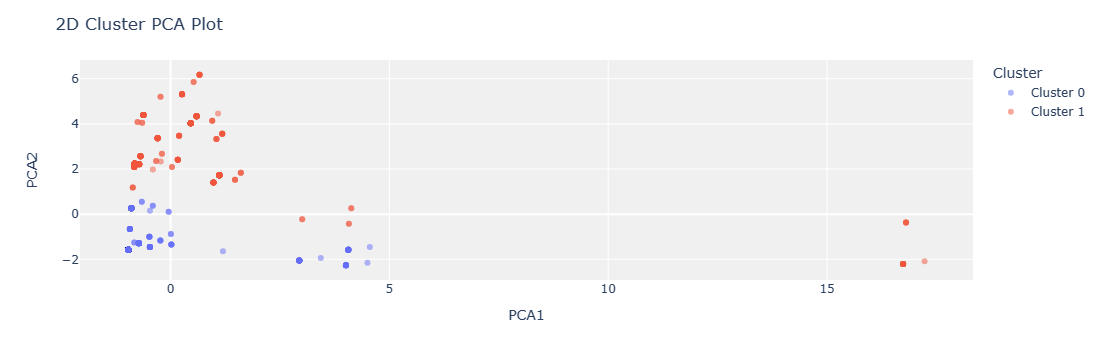

In [8]:
plot_model(kmeans)